# Introducion
En este notebook se aplica Kmeans Clustering al dataset conocido como 'Wholesales Customer Dataset' (https://archive.ics.uci.edu/ml/datasets/wholesale+customers)

Se ejecutan los siguientes pasos
* Cargar los datos
* Describir las variables
* Estudia las variables categoricas
* Filtrar anomalias
* Calcula la suma de la distancia quadradica de cada punto de su centroide para multiples numeros de clusters
* Elije un numero de clusters por dataset

In [1]:
import pandas as pd
from sklearn.cluster import KMeans
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
T = pd.read_csv('wholesale.csv')
T.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [3]:
T.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [4]:
T.isna().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

# Descripcion de los datos
Tenemos 440 puntos de datos con 8 features, de cuales dos son categorías y las de más nominales.

No tenemos datos faltantes, pero parece que tenemos anamolias (como se puede ver en la tabla generado por .describe() con valores max y min muy diferente al quantil 0.25 y 0.75). Por eso vamos a visualizar la distribución de los datos.

Ademas vamos a ver si estas dos variables categorías están separando los datos en grupos de usuario distintos o si no tienen ningún efecto.

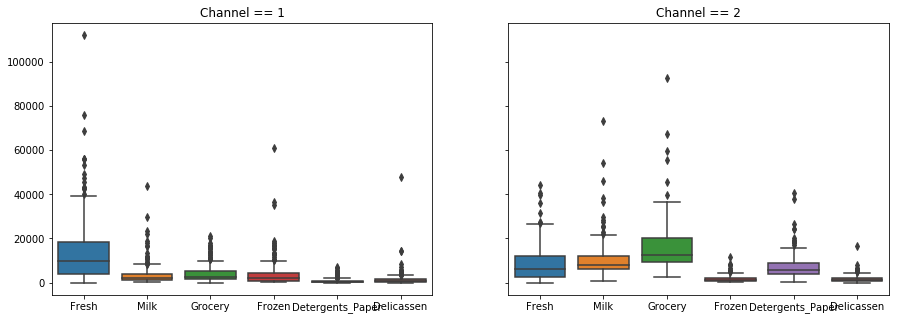

In [5]:
# Check effect of Channel
channels = sorted(T['Channel'].unique())
f, axes = plt.subplots(1, len(channels), sharey=True, figsize=(15, 5))
for i, ch in enumerate(channels):
    sns.boxplot(data=T[T['Channel']==ch].drop(['Channel', 'Region'], axis=1), ax=axes[i])
    axes[i].set_title('Channel == %d'%ch)
plt.show()

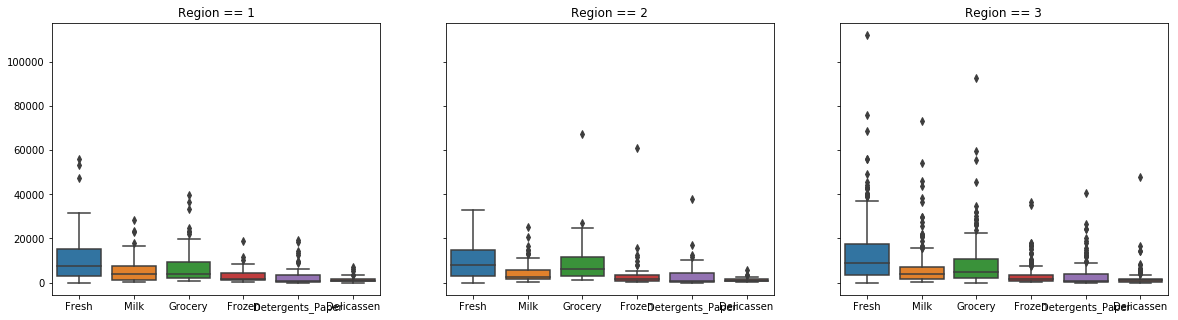

In [6]:
# Check effect of Channel
cats = sorted(T['Region'].unique())
f, axes = plt.subplots(1, len(cats), sharey=True, figsize=(5*(len(cats)+1), 5))
for i, v in enumerate(cats):
    sns.boxplot(data=T[T['Region']==v].drop(['Channel', 'Region'], axis=1), ax=axes[i])
    axes[i].set_title('Region == %d'%v)
plt.show()

# Pre procesamento de los datos
Las diferentes channels tienen distribuciónes distintas. Para mejorar el agrupoamiento, voy a seperar el dataset basado en el channel y generar agrupamientos para cada canal de distribución.

La Region al otro lado no parece tener influencia a la distribución de datos, por eso voy a quitar esta variable para calcular al agrupamiento.

Vamos a quitar outliers utilizando el metodo winsorizing, que subsitute valors enzima o abajo del quantil 0.05 y 0.95 por el valor del quantil.

In [7]:
def winsorizing(data, lq=0.05, uq=0.95):
    lqs = data.quantile(q=lq)
    uqs = data.quantile(q=uq)
    
    # Replace too low values
    for col, q in lqs.iteritems():
        data[col]
        data.loc[data[col] < q, col] = q
        
    # Replace too high values
    for col, q in uqs.iteritems():
        data[col]
        data.loc[data[col] > q, col] = q

In [8]:
C1 = T[T['Channel']==1].drop(['Channel', 'Region'], axis=1)
C2 = T[T['Channel']==2].drop(['Channel', 'Region'], axis=1)

# Filter outliers, replacing them with 0.05 and 0.95 quantiles
winsorizing(C1)
winsorizing(C2)

# Standadize features
NC1 = (C1 - C1.mean()) / C1.std()
NC2 = (C2 - C2.mean()) / C2.std()

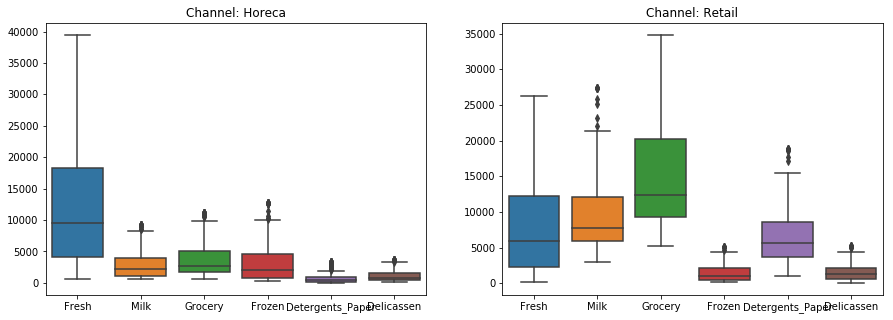

In [9]:
# Distribution after outlier replacement
f, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].set_title('Channel: Horeca')
axes[1].set_title('Channel: Retail')
sns.boxplot(data=C1, ax=axes[0])
sns.boxplot(data=C2, ax=axes[1])
plt.show()

# Numero de clusters
Para encontrar el numero de clusters, vamos a utilizar el 'elbow plot' que enseña la suma de las distancias cuadrados (TSS)
de cada punto de su centroide. Como heurística se utiliza el numero de clusteres que disminuye la TSS gravemente al respecto de los demás.

In [10]:
def Krange(data, Nmax, seed=42, **kwargs):
    models = []
    for N in range(2, Nmax+1):
        models.append(KMeans(n_clusters=N, random_state=seed, **kwargs).fit(data))
    sum_of_squares = [m.inertia_ for m in models]

    f, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.plot(range(2, 1 +  Nmax), sum_of_squares)
    ax.set_xlabel('# Clusters')
    ax.set_ylabel('Total Sum of Square distance from centroids')
    
    return models, sum_of_squares, f

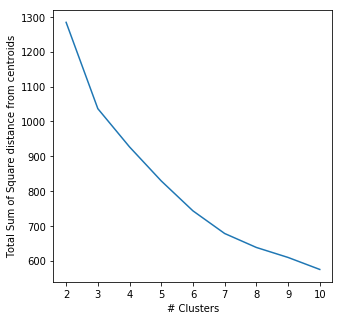

In [11]:
models_c1, sq_c1, f_c1 = Krange(NC1, 10)
plt.show(f_c1)

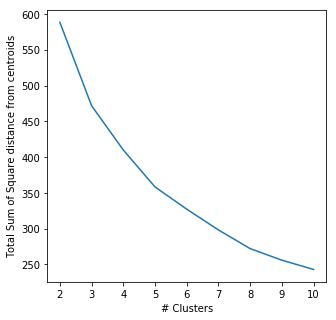

In [12]:
models_c2, sq_c2, f_c2 = Krange(NC2, 10)
plt.show(f_c2)

# Numero de clusters
No es obvio cuantos clusters debemos utilizar para separar los datos.
Hay diferentes opciones, pero la mejor selección parce ser 7 clusters para el dataset C1 (Channel = Horeca) y 5 para C2 (Channel = Retail), orque en estos puntos el delta TSS cambia fuertamente (que tambien es cierto para 3 clusteres, pero por rasones del 'marketing' por ejemplo creo sea más utiliz tener más de dos grupos)